In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)     # input 1x28x28 -> output 6x24x24
        self.pool = nn.AvgPool2d(2, 2)      # output 6x12x12
        self.conv2 = nn.Conv2d(6, 16, 5)    # output 16x8x8
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        activations = {}
        x = F.relu(self.conv1(x))
        activations['conv1'] = x.detach().cpu()
        x = self.pool(x)
        activations['pool1'] = x.detach().cpu()
        x = F.relu(self.conv2(x))
        activations['conv2'] = x.detach().cpu()
        x = self.pool(x)
        activations['pool2'] = x.detach().cpu()
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        activations['fc1'] = x.detach().cpu()
        x = F.relu(self.fc2(x))
        activations['fc2'] = x.detach().cpu()
        x = self.fc3(x)
        activations['output'] = x
        return activations

model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
# Assuming 'model' is your PyTorch model instance
conv_layer = model.conv1 # Replace 'conv1' with the actual layer name

# 1. Access the weight tensor
kernel_tensor = conv_layer.weight

# 2. Detach from the graph and move to CPU for printing/analysis
kernel_values = kernel_tensor.detach().cpu().numpy()

# 3. Print the shape and values
print(f"Kernel Shape: {kernel_values.shape}")
print(f"Kernel Values:\n{kernel_values}")

Kernel Shape: (6, 1, 5, 5)
Kernel Values:
[[[[ 0.01609964  0.01028268 -0.08077908 -0.14204021  0.08560901]
   [-0.06636622  0.18085466  0.14309168 -0.08897906  0.090779  ]
   [ 0.1765983   0.17892341  0.07433682  0.14774852  0.12112167]
   [-0.02963083  0.00492935  0.18767153  0.17898417  0.04759135]
   [-0.02049792 -0.19566742 -0.06738754 -0.17328362 -0.03336382]]]


 [[[ 0.18169546 -0.09050035 -0.0918875   0.06641605 -0.11998194]
   [-0.16362424 -0.16617246 -0.16341583 -0.0977804  -0.09777315]
   [ 0.0151989   0.14961982  0.12590264 -0.00760329 -0.11282964]
   [-0.14376223 -0.05939887  0.19120996 -0.10846093  0.03447254]
   [-0.13902996 -0.17493768  0.14857684 -0.16637662  0.15173201]]]


 [[[ 0.17423499  0.08966871  0.04820745  0.02725027 -0.19407569]
   [ 0.1286329  -0.17652965 -0.08260877  0.01952047  0.1613405 ]
   [ 0.1712296  -0.1869529  -0.04562102  0.05326099 -0.08433666]
   [ 0.09839928 -0.05034781 -0.12050333 -0.05419836  0.15042925]
   [ 0.09775849  0.12643535  0.1794254  

In [6]:
# Squeeze the In_Channels dimension if it's 1 (e.g., for MNIST)
kernels_to_plot = kernel_values.squeeze(axis=1)

# The new shape is (Out_Channels, H, W)
num_filters = kernels_to_plot.shape[0]
kernel_height = kernels_to_plot.shape[1]

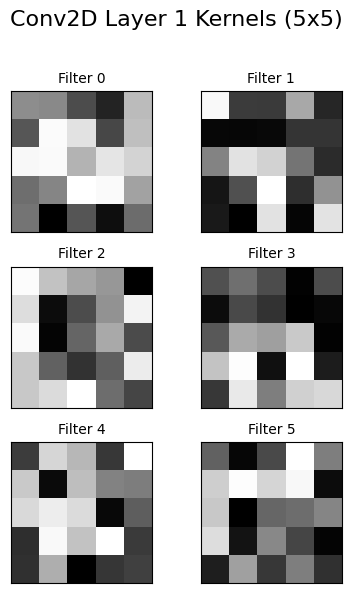

In [9]:
# Determine the grid size (e.g., 8x8, 4x8, etc.)
rows = int(np.ceil(np.sqrt(num_filters)))
cols = int(np.ceil(num_filters / rows))

fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
fig.suptitle(f"Conv2D Layer 1 Kernels ({kernel_height}x{kernel_height})", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_filters:
        # Use imshow to display the 2D kernel slice
        ax.imshow(kernels_to_plot[i], cmap='gray')
        ax.set_title(f'Filter {i}', fontsize=10)
    
    # Hide axis ticks for a cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()

In [19]:
# =========================================
# 4. Training Setup
# =========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses, test_accuracies = [], []

In [20]:
# =========================================
# 5. Before Training (Baseline Evaluation)
# =========================================
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            activations = model(data)
            outputs = activations["output"].to(device)  # 🔹 Extract final predictions

            _, predicted = torch.max(outputs, 1)  # 🔹 Get class with highest probability
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

print("Before training, test accuracy:", evaluate(model, test_loader))

Before training, test accuracy: 9.85


In [22]:
# =========================================
# 6. Train Model
# =========================================
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        activations = model(data)
        outputs = activations["output"].to(device)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    test_acc = evaluate(model, test_loader)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

Epoch [1/5] - Loss: 0.0919 | Test Accuracy: 97.57%
Epoch [2/5] - Loss: 0.0651 | Test Accuracy: 98.32%
Epoch [3/5] - Loss: 0.0506 | Test Accuracy: 98.51%
Epoch [4/5] - Loss: 0.0411 | Test Accuracy: 98.66%
Epoch [5/5] - Loss: 0.0342 | Test Accuracy: 98.79%


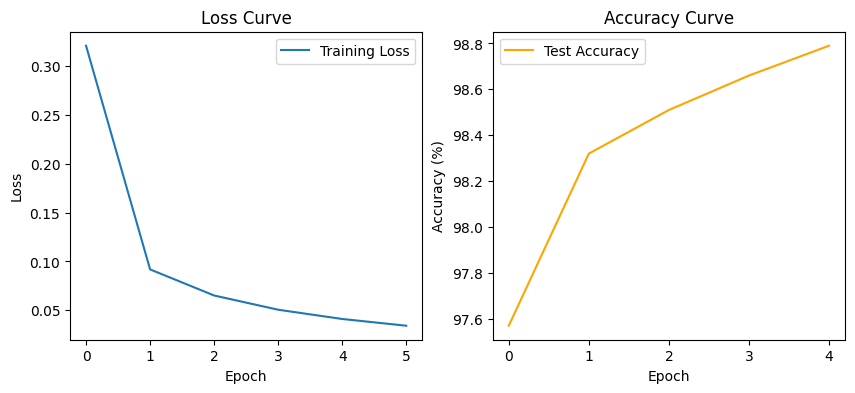

Final Test Accuracy: 98.79


In [23]:
# =========================================
# 7. Visualization
# =========================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

# =========================================
# 8. Final Evaluation
# =========================================
final_acc = evaluate(model, test_loader)
print("Final Test Accuracy:", final_acc)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [50]:
import pygame
import numpy as np
import torch

# === 3. Visualization Helper ===
def tensor_to_surface(tensor):
    """Convert tensor [C,H,W] or [H,W] to Pygame surface."""
    tensor = tensor.detach().cpu()
    if tensor.dim() == 3:
        tensor = tensor[0]  # get first channel if grayscale
    array = tensor.numpy()
    array = (array - array.min()) / (array.max() - array.min() + 1e-5)  # normalize 0-1
    array = (array * 255).astype(np.uint8)
    surf = pygame.surfarray.make_surface(array)
    return pygame.transform.scale(surf, (64, 64))

# === 4. Visualization Function ===
def visualize_layers(model, loader, device):
    pygame.init()
    screen = pygame.display.set_mode((800, 600))
    pygame.display.set_caption("LeNet Layer Visualization")
    clock = pygame.time.Clock()

    font = pygame.font.SysFont("Arial", 20)
    running = True
    iterator = iter(loader)

    while running:
        try:
            data, target = next(iterator)
        except StopIteration:
            iterator = iter(loader)
            data, target = next(iterator)

        # Take only the first sample from the batch
        data = data[0:1].to(device)
        target = target[0].to(device)

        model.eval()
        with torch.no_grad():
            activations = model(data)

        # Extract layers you want to visualize
        conv1_maps = activations["conv1"][0].cpu()
        pool1_maps = activations["pool1"][0].cpu()
        conv2_maps = activations["conv2"][0].cpu()
        pool2_maps = activations["pool2"][0].cpu()

        screen.fill((20, 20, 20))

        # Draw input image
        input_img = tensor_to_surface(data[0])
        screen.blit(input_img, (30, 50))
        screen.blit(font.render("Input", True, (255, 255, 255)), (30, 20))

        # Draw Conv1 activations
        for i in range(min(6, conv1_maps.shape[0])):
            img = tensor_to_surface(conv1_maps[i])
            screen.blit(img, (150 + i * 70, 50))
        screen.blit(font.render("Conv1", True, (255, 255, 255)), (150, 20))

        # Draw Pool1 activations
        for i in range(min(6, pool1_maps.shape[0])):
            img = tensor_to_surface(pool1_maps[i])
            screen.blit(img, (150 + i * 70, 150))
        screen.blit(font.render("Pool1", True, (255, 255, 255)), (150, 120))

        # Draw Conv2 activations
        for i in range(min(6, conv2_maps.shape[0])):
            img = tensor_to_surface(conv2_maps[i])
            screen.blit(img, (150 + i * 70, 250))
        screen.blit(font.render("Conv2", True, (255, 255, 255)), (150, 220))

        # Draw Pool2 activations
        for i in range(min(6, pool2_maps.shape[0])):
            img = tensor_to_surface(pool2_maps[i])
            screen.blit(img, (150 + i * 70, 350))
        screen.blit(font.render("Pool2", True, (255, 255, 255)), (150, 320))

        # Prediction (single image)
        p = activations["output"]
        _, pred = torch.max(p, 1)
        pred = pred.item()
        label = target.item()
        screen.blit(font.render(f"Predicted: {pred} | Label: {label}", True, (0, 255, 0)), (30, 500))

        pygame.display.flip()
        clock.tick(1)  # show 1 sample per second

        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                # Skip to next sample manually
                break

    pygame.quit()


In [51]:
visualize_layers(model, test_loader, device)